# Introduction to Deep Learning 

### Import Packages

We split the import up into two parts. We have to specify where CUDA is before we imoprt Keras. This is only neccessary if we want CUDA for training.

In [12]:
import pickle
import os

#os.environ["PATH"] += "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\bin" 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Add, Concatenate, Dropout, Conv1D, LSTM, ZeroPadding2D, Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation, SpatialDropout2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from keras import optimizers
from keras.regularizers import l2
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import librosa
import scipy
import soundfile as sf
import pydot

### Import Data

We import the pkl files. These files have to be in the same folder as this .py file.

In [14]:
# load pkl files
with open('denoise_dataset.pkl', 'rb') as file:
    data = pickle.load(file)
    
with open('denoise_testset_noisy.pkl', 'rb') as file:
    test_data = pickle.load(file)

We split up the train data into originals (Y) and noisy (X).

In [15]:
originals = data[0]
noisy = data[1]
print("Noisy Shape: " + str(noisy.shape))
print("Original Shape: " + str(originals.shape))

Noisy Shape: (9600, 5500)
Original Shape: (9600, 11000)


### Data preparation

Here we downsample all the parts we need to train the first model (Denoiser). Both have to be equal size for the implemented architecture to work. Therefore, we only downsample the originals to 5500.

In [16]:
originals_downsampled = []
for i in range(len(originals)):
    originals_downsampled.append(librosa.core.resample(originals[i], orig_sr=11000, target_sr=5500))

originals_downsampled = np.array(originals_downsampled)

Next, we transform the time series data (1D) into a 2D representation. We do so by using a short-transform fourier transform. Altough Librosa recommends 512 for human voices, we opt for a sample rate of 256 instead. This allows us to create a bigger network.

In [17]:
# convert series data to fourier domain
sft = 256

originals_downsampled_fourier = []
for i in originals_downsampled:
    originals_downsampled_fourier.append(librosa.stft(i, n_fft=sft, dtype=np.float64))

originals_downsampled_fourier = np.array(originals_downsampled_fourier)

noisy_fourier = []
for i in noisy:
    noisy_fourier.append(librosa.stft(i, n_fft=sft, dtype=np.float64))

noisy_fourier = np.array(noisy_fourier)

test_data_fourier = []
for i in test_data:
    test_data_fourier.append(librosa.stft(i, n_fft=sft, dtype=np.float64))

test_data_fourier = np.array(test_data_fourier)

We verify the input shapes of our network.

In [8]:
originals_downsampled_fourier.shape

(9600, 129, 86)

In [9]:
test_data_fourier.shape

(320, 129, 86)

In [10]:
noisy_fourier.shape

(9600, 129, 86)

### Model Definition: Denoiser

This architecture is largely adapted from "A Fully Convultional Neural Network for Speech Enhancement" by Park and Lee (2016). The network applies multiple layers of Convulation 2D, a ReLU activation and Batch Normalization. This network can largely be split up in three parts: an encoder, a bottleneck and a decoder. There are B blocks for the encoder and decoder part. In addition, there's 1 bottleneck layer and a final layer. Therefore, we have 2B + 2 blocks. The original network was made up of 33k parameters. This network has 55k parameters. In order to make sure our network continues to train well, we added multiple skip connections. We use ADAM and MSE like mentioned in the paper.

In [18]:
def build_model_denoise(l2_strength):
    inputs = Input(shape=[129, 86,1])
    x = inputs

    x = ZeroPadding2D(((4,4), (0,0)))(x)
    
    # -----B1
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='valid', use_bias=False, kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----B2
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # -----B3
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip2 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(skip2)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)


    # -----B4
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip3 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(skip3)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # -----Bottleneck
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
                  kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
        # -----B4
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = x + skip3
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # -----B3
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = x + skip2
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # -----B2
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----B1
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
                kernel_regularizer=l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)


    # ----
    x = SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model_denoise = Model(inputs=inputs, outputs=x)
    
    model_denoise.compile(optimizer="Adam", loss='mse')
    return model_denoise

In [19]:
model_denoise = build_model_denoise(l2_strength=0.0)
model_denoise.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 129, 86, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 137, 86, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 129, 86, 18)  162         ['zero_padding2d[0][0]']         
                                                                                                  
 activation (Activation)        (None, 129, 86, 18)  0           ['conv2d[0][0]']             

 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 129, 86, 8)   2160        ['batch_normalization_10[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 129, 86, 8)   0           ['conv2d_11[0][0]']              
                                                                                                  
 batch_normalization_11 (BatchN  (None, 129, 86, 8)  32          ['activation_11[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_12 (Conv2D)             (None, 129, 86, 18)  1296        ['batch_normalization_11[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)             (None, 129, 86, 30)  2700        ['batch_normalization_21[0][0]'] 
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 129, 86, 30)  0          ['conv2d_22[0][0]',              
 mbda)                                                            'conv2d_4[0][0]']               
                                                                                                  
 activation_22 (Activation)     (None, 129, 86, 30)  0           ['tf.__operators__.add_2[0][0]'] 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 129, 86, 30)  120        ['activation_22[0][0]']          
 ormalizat

We build a plot for our model, which is used as a reference for the plots in the paper

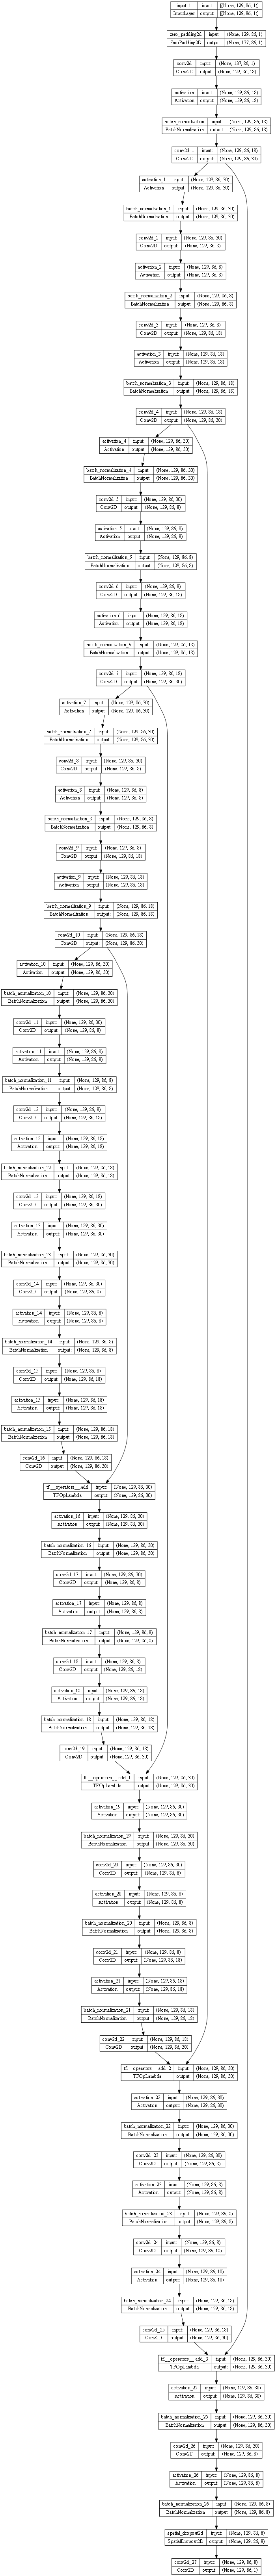

In [20]:
tf.keras.utils.plot_model(model_denoise, show_shapes=True, dpi=64)

We train the model with 10 epochs, a validation split of 0.1 and batch size 32. These parameters were set because they are commonly used in DL training. The epochs were kept low to prevent a longer training time for almost no loss reduction.

In [21]:
model_denoise.fit(noisy_fourier, originals_downsampled_fourier, epochs=10 , validation_split = 0.1, batch_size = 16)

Epoch 1/10
540/540 [==============================] - 24s 35ms/step - loss: 0.6142 - val_loss: 0.2420
Epoch 2/10
540/540 [==============================] - 19s 35ms/step - loss: 0.2904 - val_loss: 0.2264
Epoch 3/10
540/540 [==============================] - 19s 36ms/step - loss: 0.2788 - val_loss: 0.2205
Epoch 4/10
540/540 [==============================] - 20s 36ms/step - loss: 0.2758 - val_loss: 0.2156
Epoch 5/10
540/540 [==============================] - 19s 36ms/step - loss: 0.2680 - val_loss: 0.2207
Epoch 6/10
540/540 [==============================] - 19s 36ms/step - loss: 0.2618 - val_loss: 0.2145
Epoch 7/10
540/540 [==============================] - 19s 35ms/step - loss: 0.2593 - val_loss: 0.2066
Epoch 8/10
540/540 [==============================] - 19s 35ms/step - loss: 0.2578 - val_loss: 0.2123
Epoch 9/10
540/540 [==============================] - 19s 35ms/step - loss: 0.2570 - val_loss: 0.2050
Epoch 10/10
540/540 [==============================] - 19s 35ms/step - loss: 0.254

# 

In [22]:
model_denoise.save("Denoise model")
model_denoise = load_model('Denoise model')

INFO:tensorflow:Assets written to: Denoise model\assets


INFO:tensorflow:Assets written to: Denoise model\assets


In [23]:
class Subpixel1D(tf.keras.layers.Layer):
    def __init__(self,
                 r,
                 **kwargs):
        super(Subpixel1D, self).__init__(**kwargs)
        self.r = r
        
    def build(self, input_shape):
        # check if channels are evenly divisible for subpixel1d to work!
        input_shape = tf.TensorShape(input_shape).as_list()
        if input_shape[2] % self.r != 0:
            raise ValueError(
                f'The number of input channels must be evenly divisible by the upsampling '
                f'factor r. Received r={self.r}, but the input has {input_shape[2]} channels '
                f'(full input shape is {input_shape}).'
            )
        
    def call(self, inputs):
        # (batch, samples, channels) -> (channels, samples, batch)
        outputs = tf.transpose(inputs, [2, 1, 0])
        # (channels, samples, batch) -> (channels/r, r*samples, batch)
        outputs = tf.batch_to_space(outputs, [self.r], [[0, 0]])
        # (channels, samples, batch) -> (batch, samples, channels)
        outputs = tf.transpose(outputs, [2, 1, 0])
        return outputs
    
    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        return (input_shape[0], input_shape[1] * self.r, input_shape[2] // self.r)

    def get_config(self):
        config = {
            'r': self.r,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [24]:
def build_model_upscale(strides):
    inputs = tf.keras.Input(shape=(5500, 1))

    d = tf.keras.layers.Conv1D(16, kernel_size=64, strides=strides,
                               padding='same', activation='elu',
                               kernel_initializer='he_normal')(inputs)
    d = BatchNormalization()(d) #ex
    d = tf.keras.layers.Conv1D(32, kernel_size=32, strides=strides, padding='same',
                               activation='elu', kernel_initializer='he_normal')(d)
    d = BatchNormalization()(d) #ex
    bottleneck = tf.keras.layers.Conv1D(32, kernel_size=8,
                                        strides=1, padding='same',
                                        activation='elu',
                                        kernel_initializer='he_normal',
                                        name='bottleneck')(d)
    u = Subpixel1D(r=strides)(bottleneck)
    u = tf.keras.layers.Conv1D(32, kernel_size=32, strides=1, padding='same',
                               activation='elu', kernel_initializer='he_normal')(u)
    u = Subpixel1D(r=strides)(u)
    u = tf.keras.layers.Conv1D(strides, kernel_size=64, strides=1, padding='same',
                               activation='elu', kernel_initializer='he_normal')(u)
    outputs = Subpixel1D(r=strides)(u)

    model_upscale = tf.keras.Model(inputs=inputs, outputs=outputs)

    model_upscale.compile(optimizer="Adam", loss="mse")
    return model_upscale

In [25]:
model_upscale = build_model_upscale(2)
model_upscale.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5500, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2750, 16)          1040      
                                                                 
 batch_normalization_27 (Bat  (None, 2750, 16)         64        
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 1375, 32)          16416     
                                                                 
 batch_normalization_28 (Bat  (None, 1375, 32)         128       
 chNormalization)                                                
                                                                 
 bottleneck (Conv1D)         (None, 1375, 32)          8224

In [26]:
model_upscale.fit(x=originals_downsampled, y=originals, epochs=10)

Epoch 1/10
300/300 [==============================] - 3s 8ms/step - loss: 0.0494
Epoch 2/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 3/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0044
Epoch 4/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0040
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0036
Epoch 6/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0034
Epoch 7/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0032
Epoch 8/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0031
Epoch 9/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0030
Epoch 10/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0028


In [29]:
model_upscale.save("Upscale model")

INFO:tensorflow:Assets written to: Upscale model\assets


INFO:tensorflow:Assets written to: Upscale model\assets


In [30]:
test_data_predictions_fourier = model_denoise.predict(test_data_fourier)
test_data_predictions_fourier = test_data_predictions_fourier.reshape(320, 129, 86)

test_data_predictions = []
for i in range(len(test_data_predictions_fourier)):
    test_data_predictions.append(librosa.istft(test_data_predictions_fourier[i], n_fft=256, length=5500))
    
test_data_predictions = np.array(test_data_predictions)

test_data_predictions_upscaled = model_upscale.predict(test_data_predictions)
test_data_predictions_upscaled = test_data_predictions_upscaled.reshape(320, 11000)

10/10 [==============================] - 0s 3ms/step


In [31]:
test_data_fourier.shape

(320, 129, 86)

In [ ]:
lines = []
for i in test_data_predictions_upscaled:
    string = str(i[0])
    for j in range(1, len(i)):
        string = string + ";" + str(i[j])
    string = string + "\n"
    lines.append(string)
    
f = open("answer.txt", "w")
f.writelines(lines)
f.close()